In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import re
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as LightGBM

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import validation_curve, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import learning_curve, validation_curve

In [7]:
train = pd.read_csv('../DataSet/train_raw4_3.csv')
test = pd.read_csv('../DataSet/test_raw4_3.csv')
test.head()

,month_07,month_08,month_09,Temperature,RH,Rain,DC,FWI,FWI/FFMC,(DMC/FWI)/ISI,FWI/BUI,Classes_not fire
0,0,1,0,0.539809,0.183304,-0.381541,-0.407647,-0.123939,-0.116753,0.282218,0.772126,0
1,1,0,0,-0.280475,1.120883,-0.381541,1.937482,0.482772,0.551271,-0.340266,-0.192739,0
2,0,1,0,1.906949,-1.557913,-0.289191,-0.281897,0.482772,0.484829,-0.274967,1.351745,0
3,0,0,1,-1.100759,1.455733,-0.381541,0.024757,-0.097561,-0.057226,0.234476,0.232373,0
4,0,0,1,-0.280475,-0.486395,-0.381541,0.214485,0.166227,0.177777,-0.020045,0.384570,0


In [8]:

train['(DMC/FWI)/ISI'].replace(to_replace=np.inf, value=np.nan, inplace=True)
train['(DMC/FWI)/ISI'].replace(to_replace=np.nan, value=train['(DMC/FWI)/ISI'].mean(), inplace=True)
train['FWI/BUI'].replace(to_replace='inf', value=np.nan, inplace=True)
train['FWI/BUI'].replace(to_replace=np.nan, value=train['FWI/BUI'].mean(), inplace=True)
train['FWI/FFMC'].replace(to_replace='inf', value=np.nan, inplace=True)
train['FWI/FFMC'].replace(to_replace=np.nan, value=train['FWI/FFMC'].mean(), inplace=True)


############################

test['(DMC/FWI)/ISI'].replace(to_replace=np.inf, value=np.nan, inplace=True)
test['(DMC/FWI)/ISI'].replace(to_replace=np.nan, value=test['(DMC/FWI)/ISI'].mean(), inplace=True)
test['FWI/BUI'].replace(to_replace='inf', value=np.nan, inplace=True)
test['FWI/BUI'].replace(to_replace=np.nan, value=test['FWI/BUI'].mean(), inplace=True)
test['FWI/FFMC'].replace(to_replace='inf', value=np.nan, inplace=True)
test['FWI/FFMC'].replace(to_replace=np.nan, value=test['FWI/FFMC'].mean(), inplace=True)

#############################################
#train.drop(['month_07','month_08', 'month_09'],axis = 1, inplace=True)
#test.drop(['month_07','month_08', 'month_09'],axis = 1, inplace=True)


In [9]:
train.head()

,month_07,month_08,month_09,Temperature,RH,Rain,DC,FWI,FWI/FFMC,(DMC/FWI)/ISI,FWI/BUI,Classes_not fire
0,0,0,0,0.266381,-0.821244,-0.381541,0.984429,0.772938,0.795832,-0.379876,0.477521,0
1,1,0,0,0.539809,1.254823,-0.381541,-0.242187,-0.480053,-0.465379,0.551357,-0.174961,1
2,0,0,1,-0.827331,0.183304,-0.104489,-0.727538,-0.836166,-0.845626,-0.220413,-0.845911,1
3,1,0,0,0.539809,-1.156094,-0.381541,-0.531191,0.931211,0.921712,-0.533633,1.823222,0
4,0,0,1,-0.553903,1.187853,-0.381541,-0.301753,-0.440485,-0.429440,0.960935,0.138587,0


In [10]:
train['month_07'] = train['month_07'].astype('uint8')
train['month_08'] = train['month_08'].astype('uint8')
train['month_09'] = train['month_09'].astype('uint8')
train['Classes_not fire'] = train['Classes_not fire'].astype('uint8')

test['month_07'] = test['month_07'].astype('uint8')
test['month_08'] = test['month_08'].astype('uint8')
test['month_09'] = test['month_09'].astype('uint8')
test['Classes_not fire'] = test['Classes_not fire'].astype('uint8')

In [11]:
train.dtypes

month_07              uint8
month_08              uint8
month_09              uint8
Temperature         float64
RH                  float64
Rain                float64
DC                  float64
FWI                 float64
FWI/FFMC            float64
(DMC/FWI)/ISI       float64
FWI/BUI             float64
Classes_not fire      uint8
dtype: object

In [12]:
test.dtypes

month_07              uint8
month_08              uint8
month_09              uint8
Temperature         float64
RH                  float64
Rain                float64
DC                  float64
FWI                 float64
FWI/FFMC            float64
(DMC/FWI)/ISI       float64
FWI/BUI             float64
Classes_not fire      uint8
dtype: object

In [13]:
train['Classes_not fire'].unique()

array([0, 1], dtype=uint8)

In [14]:
test['Classes_not fire'].unique()

array([0, 1], dtype=uint8)

In [15]:
X_train = train.iloc[:,:-1]
X_test = test.iloc[:,:-1]

#X_test.head()
X_train.head()

,month_07,month_08,month_09,Temperature,RH,Rain,DC,FWI,FWI/FFMC,(DMC/FWI)/ISI,FWI/BUI
0,0,0,0,0.266381,-0.821244,-0.381541,0.984429,0.772938,0.795832,-0.379876,0.477521
1,1,0,0,0.539809,1.254823,-0.381541,-0.242187,-0.480053,-0.465379,0.551357,-0.174961
2,0,0,1,-0.827331,0.183304,-0.104489,-0.727538,-0.836166,-0.845626,-0.220413,-0.845911
3,1,0,0,0.539809,-1.156094,-0.381541,-0.531191,0.931211,0.921712,-0.533633,1.823222
4,0,0,1,-0.553903,1.187853,-0.381541,-0.301753,-0.440485,-0.429440,0.960935,0.138587


In [16]:
y_train = train['Classes_not fire']
y_test = test[['Classes_not fire']]
y_train.head()

0    0
1    1
2    1
3    0
4    0
Name: Classes_not fire, dtype: uint8

# Model Training: Classification

## LightGBM

In [32]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# load data
lgb_model = LightGBM
# define parameter grid
param_lightGBM = {'n_estimators':[100,400],
    'learning_rate': [0.05, 0.1, 0.2,1],
    'num_leaves': [10, 20, 30],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.5,],
    'reg_lambda': [0, 0.5,]
}

# define LightGBM model
lgb_model = lgb.LGBMClassifier(objective='binary', metric=['f1','auc','binary_logloss'])

# define GridSearchCV object
grid_search = GridSearchCV(estimator=lgb_model,
                           param_grid=param_lightGBM,
                           refit='roc_auc',
                           scoring=['f1','roc_auc'],
                           cv=5,
                           verbose=3
                          )

# perform grid search
grid_search.fit(X_train, y_train)

# print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)



Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV 1/5] END learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=100, num_leaves=10, reg_alpha=0, reg_lambda=0; f1: (test=1.000) roc_auc: (test=1.000) total time=   0.3s
[CV 2/5] END learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=100, num_leaves=10, reg_alpha=0, reg_lambda=0; f1: (test=1.000) roc_auc: (test=1.000) total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=100, num_leaves=10, reg_alpha=0, reg_lambda=0; f1: (test=0.944) roc_auc: (test=0.989) total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=100, num_leaves=10, reg_alpha=0, reg_lambda=0; f1: (test=1.000) roc_auc: (test=1.000) total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=100, num_leaves=10, reg_alpha=0, reg_lambda=0; f1: (test=0.971) roc_auc: (test=1.000) total time=   0.0s
[

In [33]:
# predict on test set
y_pred  = grid_search.best_estimator_.predict(X_test)
print("Test F1 Score:", f1_score(y_test, y_pred))
print("Test roc_auc Score:", roc_auc_score(y_test, y_pred))
print("Test Accuracy Score:", accuracy_score(y_test, y_pred))
print("Test Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))



Test F1 Score: 0.9714285714285714
Test roc_auc Score: 0.9722222222222222
Test Accuracy Score: 0.9795918367346939
Test Balanced Accuracy Score: 0.9722222222222222


In [35]:
filename = 'tuned_' + re.search(r'^[^\(]+', str(grid_search.best_estimator_))[0] + '_model.pkl'
filepath = os.path.join('../tuned_models_raw4_3_without_month', filename)
with open(filepath, 'wb') as file:
    pickle.dump(grid_search, file)


## DecisionTree and GaussianNB

In [31]:
#dtc = DecisionTreeClassifier()
clfs = {
    'DecisionTrees': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
    
    }

param_grid = {
    
    'GaussianNB':{},
    
    'DecisionTrees':{'criterion': ['gini', 'entropy', 'log_loss'],
                    'max_depth':[1,2,3,4,5,6,7,8,9,10,12,14,16],
                    'splitter':['best','random']},

    }

##################################
def train_classifier(clf,parameters):
    
    gs = GridSearchCV(clf,param_grid=parameters, cv=5,refit='roc_auc', verbose=2, scoring=['f1','roc_auc']).fit(X_train, y_train)
    #y_pred = gs.predict(X_test)    
    
    
    return gs
########################################
tuned_models = []

for name,clf in clfs.items():
    
    print("\nFor ",name)
    parameters = param_grid[name]
    current_best_model = train_classifier(clf,parameters)
    
    ####### Saving Trainined MOdel #####################
    
    # create the directory if it does not exist
    if not os.path.exists('../tuned_models_raw4_3_without_month'):
        os.makedirs('../tuned_models_raw4_3_without_month')

    filename = 'tuned_' + re.search(r'^[^\(]+', str(current_best_model.best_estimator_))[0] + '_model.pkl'
    filepath = os.path.join('../tuned_models_raw4_3_without_month', filename)
    with open(filepath, 'wb') as file:
        pickle.dump(current_best_model, file)
            
    ##############################################################################
    
    tuned_models.append(current_best_model)



For  DecisionTrees
Fitting 5 folds for each of 78 candidates, totalling 390 fits
[CV] END .........criterion=gini, max_depth=1, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=1, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=1, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=1, splitter=best; total time=   0.0s
[CV] END .........criterion=gini, max_depth=1, splitter=best; total time=   0.0s
[CV] END .......criterion=gini, max_depth=1, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=1, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=1, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=1, splitter=random; total time=   0.0s
[CV] END .......criterion=gini, max_depth=1, splitter=random; total time=   0.0s
[CV] END .........criterion=gini, max_depth=2, splitter=best; total time=   0.0s
[CV] END .........criterion

## All Other Models

In [21]:
lr = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
adaBoost = AdaBoostClassifier()
#lgbm = LGBMClassifier()
gbt = GradientBoostingClassifier()

In [22]:
clfs = {
    'LogisticRegression': lr,
    'SVC': svc,
    'KNeighbors': knn,
    'RandomForest': rf,
    'AdaBoost': adaBoost,
    
    'GradientBoostingTrees': gbt
}

In [23]:
param_grid = {
    
    'LogisticRegression':{'penalty':['elasticnet'],
                          'solver':['saga'],
                          'max_iter':[3000],
                          'l1_ratio':[1,0.8,0.6,0.5,0.4,0.2,0],                          
                          'C': [10e-3,10e-2,10e-1,1.0],
                         'class_weight': ['balanced',None]},
    
    'SVC': {'C':[10e-3,10e-2,10e-1,1.0],
           'kernel':['linear','rbf','sigmoid'],
           'gamma':['scale','auto']},
    
    'KNeighbors': {'n_neighbors':[3,5,9,11,13,15],  # n_neighbors should always be odd numbers
                     'weights': ['uniform','distance']},
    
    'RandomForest': {'n_estimators':[100,300],
                    'criterion':['gini','log_loss'],
                    'max_depth':[2,4,5,6,8,10,15,20],
                    'class_weight': ['balanced',None]},
    
    'AdaBoost': {'n_estimators': [50,60,70,90,100,110],
                'learning_rate': [10e-3,10e-2,10e-1,1.0]},
    
    'GradientBoostingTrees': {'loss': ['log_loss', 'exponential'],
                             'learning_rate': [10e-3,10e-2,10e-1,1.0],
                             'n_estimators': [100,200,250],
                             'max_depth': [2,3,4,5,6,7,8,9]},
    
           
    }

In [24]:
def train_classifier(clf,parameters):
    
    gs = GridSearchCV(clf,param_grid=parameters, cv=5,refit='roc_auc', verbose=2, scoring=['f1','roc_auc']).fit(X_train, y_train)
    #y_pred = gs.predict(X_test)    
    
    
    return gs

In [25]:
tuned_models = []

for name,clf in clfs.items():
    
    print("\nFor ",name)
    parameters = param_grid[name]
    current_best_model = train_classifier(clf,parameters)
    
    ####### Saving Trainined MOdel #####################
    
    # create the directory if it does not exist
    if not os.path.exists('../tuned_models_raw4_3_without_month'):
        os.makedirs('../tuned_models_raw4_3_without_month')

    filename = 'tuned_' + re.search(r'^[^\(]+', str(current_best_model.best_estimator_))[0] + '_model.pkl'
    filepath = os.path.join('../tuned_models_raw4_3_without_month', filename)
    with open(filepath, 'wb') as file:
        pickle.dump(current_best_model, file)
            
    ##############################################################################
    
    tuned_models.append(current_best_model)


For  LogisticRegression
Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END C=0.01, class_weight=balanced, l1_ratio=1, max_iter=3000, penalty=elasticnet, solver=saga; total time=   0.2s
[CV] END C=0.01, class_weight=balanced, l1_ratio=1, max_iter=3000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, l1_ratio=1, max_iter=3000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, l1_ratio=1, max_iter=3000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, l1_ratio=1, max_iter=3000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, l1_ratio=0.8, max_iter=3000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, l1_ratio=0.8, max_iter=3000, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, l1_ratio=0.8, max_iter=3000, penalty

In [ ]:
tuned_models;

# Model Import & Model Scores

In [19]:
svm_model = pickle.load(open('../Models/Classification_models/tuned_models_raw4_3/tuned_SVC_model.pkl','rb'))
AdaBoost_model = pickle.load(open('../Models/Classification_models/tuned_models_raw4_3/tuned_AdaBoostClassifier_model.pkl','rb'))
GBDT_model = pickle.load(open('../Models/Classification_models/tuned_models_raw4_3/tuned_GradientBoostingClassifier_model.pkl','rb'))
knn_model = pickle.load(open('../Models/Classification_models/tuned_models_raw4_3/tuned_KNeighborsClassifier_model.pkl','rb'))
lr_model = pickle.load(open('../Models/Classification_models/tuned_models_raw4_3/tuned_LogisticRegression_model.pkl','rb'))
RF_model = pickle.load(open('../Models/Classification_models/tuned_models_raw4_3/tuned_RandomForestClassifier_model.pkl','rb'))
lgbm_model = pickle.load(open('../Models/Classification_models/tuned_models_raw4_3/tuned_LGBMClassifier_model.pkl','rb'))

dtc_model = pickle.load(open('../Models/Classification_models/tuned_models_raw4_3/tuned_DecisionTreeClassifier_model.pkl','rb'))
GNB_model = pickle.load(open('../Models/Classification_models/tuned_models_raw4_3/tuned_GaussianNB_model.pkl','rb'))

In [20]:
#svm_model = pickle.load(open('../tuned_models_raw/tuned_SVC_model.pkl','rb'))

AdaBoost_model.best_estimator_.feature_names_in_

array(['month_07', 'month_08', 'month_09', 'Temperature', 'RH', 'Rain',
       'DC', 'FWI', 'FWI/FFMC', '(DMC/FWI)/ISI', 'FWI/BUI'], dtype=object)

In [39]:
model_scores = pd.DataFrame({
    'model': ['SVM','KNN','AdaBoost','GBDT','RF','LR','LightGBM','DecisionTrees','GaussianNB'],
    'balanced_accuracy_train': [balanced_accuracy_score(y_train,svm_model.predict(X_train)),
                                balanced_accuracy_score(y_train,knn_model.predict(X_train)),
                                balanced_accuracy_score(y_train,AdaBoost_model.predict(X_train)),
                                balanced_accuracy_score(y_train,GBDT_model.predict(X_train)),
                                balanced_accuracy_score(y_train,RF_model.predict(X_train)),
                                balanced_accuracy_score(y_train,lr_model.predict(X_train)),
                                balanced_accuracy_score(y_train,lgbm_model.predict(X_train)),
                                balanced_accuracy_score(y_train,dtc_model.predict(X_train)),
                                balanced_accuracy_score(y_train,GNB_model.predict(X_train)),
                               ]})


balanced_accuracy_test =  [balanced_accuracy_score(y_test,svm_model.predict(X_test)),
                           balanced_accuracy_score(y_test,knn_model.predict(X_test)),
                           balanced_accuracy_score(y_test,AdaBoost_model.predict(X_test)),
                           balanced_accuracy_score(y_test,GBDT_model.predict(X_test)),
                           balanced_accuracy_score(y_test,RF_model.predict(X_test)),
                           balanced_accuracy_score(y_test,lr_model.predict(X_test)),                   
                           balanced_accuracy_score(y_test,lgbm_model.predict(X_test)),
                           balanced_accuracy_score(y_test,dtc_model.predict(X_test)),
                           balanced_accuracy_score(y_test,GNB_model.predict(X_test)),  
                          ] 

f1_score_train = [f1_score(y_train,svm_model.predict(X_train)),
                  
                  f1_score(y_train,knn_model.predict(X_train)),
                  f1_score(y_train,AdaBoost_model.predict(X_train)),
                  f1_score(y_train,GBDT_model.predict(X_train)),
                  f1_score(y_train,RF_model.predict(X_train)),
                  f1_score(y_train,lr_model.predict(X_train)),
                  f1_score(y_train,lgbm_model.predict(X_train)),
                  f1_score(y_train,dtc_model.predict(X_train)),
                  f1_score(y_train,GNB_model.predict(X_train)),
                 ]


f1_score_test = [f1_score(y_test,svm_model.predict(X_test)),
                 
                 f1_score(y_test,knn_model.predict(X_test)),
                 f1_score(y_test,AdaBoost_model.predict(X_test)),
                 f1_score(y_test,GBDT_model.predict(X_test)),
                 f1_score(y_test,RF_model.predict(X_test)),
                 f1_score(y_test,lr_model.predict(X_test)),
                 f1_score(y_test,lgbm_model.predict(X_test)),
                 f1_score(y_test,dtc_model.predict(X_test)),
                 f1_score(y_test,GNB_model.predict(X_test)),
                ]

roc_auc_train =  [roc_auc_score(y_train,svm_model.predict(X_train)),
                  
                  roc_auc_score(y_train,knn_model.predict(X_train)),
                  roc_auc_score(y_train,AdaBoost_model.predict(X_train)),
                  roc_auc_score(y_train,GBDT_model.predict(X_train)),
                  roc_auc_score(y_train,RF_model.predict(X_train)),
                  roc_auc_score(y_train,lr_model.predict(X_train)),
                  roc_auc_score(y_train,lgbm_model.predict(X_train)),
                  roc_auc_score(y_train,dtc_model.predict(X_train)),
                  roc_auc_score(y_train,GNB_model.predict(X_train)),
                 ]

roc_auc_test = [roc_auc_score(y_test,svm_model.predict(X_test)),
                
                roc_auc_score(y_test,knn_model.predict(X_test)),
                roc_auc_score(y_test,AdaBoost_model.predict(X_test)),
                roc_auc_score(y_test,GBDT_model.predict(X_test)),
                roc_auc_score(y_test,RF_model.predict(X_test)),
                roc_auc_score(y_test,lr_model.predict(X_test)),
                roc_auc_score(y_test,lgbm_model.predict(X_test)),
                roc_auc_score(y_test,dtc_model.predict(X_test)),
                roc_auc_score(y_test,GNB_model.predict(X_test)),
                ] 

precision_train =  [precision_score(y_train,svm_model.predict(X_train)),
                    
                    precision_score(y_train,knn_model.predict(X_train)),
                    precision_score(y_train,AdaBoost_model.predict(X_train)),
                    precision_score(y_train,GBDT_model.predict(X_train)),
                    precision_score(y_train,RF_model.predict(X_train)),
                    precision_score(y_train,lr_model.predict(X_train)),
                    precision_score(y_train,lgbm_model.predict(X_train)),
                    precision_score(y_train,dtc_model.predict(X_train)),
                    precision_score(y_train,GNB_model.predict(X_train)),
                    
                   ]

precision_test = [precision_score(y_test,svm_model.predict(X_test)),
                  
                  precision_score(y_test,knn_model.predict(X_test)),
                  precision_score(y_test,AdaBoost_model.predict(X_test)),
                  precision_score(y_test,GBDT_model.predict(X_test)),
                  precision_score(y_test,RF_model.predict(X_test)),
                  precision_score(y_test,lr_model.predict(X_test)),
                  precision_score(y_test,lgbm_model.predict(X_test)),
                  precision_score(y_test,dtc_model.predict(X_test)),
                  precision_score(y_test,GNB_model.predict(X_test)),
                 ] 


accuracy_train =  [accuracy_score(y_train,svm_model.predict(X_train)),
                   
                   accuracy_score(y_train,knn_model.predict(X_train)),
                   accuracy_score(y_train,AdaBoost_model.predict(X_train)),
                   accuracy_score(y_train,GBDT_model.predict(X_train)),
                   accuracy_score(y_train,RF_model.predict(X_train)),
                   accuracy_score(y_train,lr_model.predict(X_train)),
                   accuracy_score(y_train,lgbm_model.predict(X_train)),
                   accuracy_score(y_train,dtc_model.predict(X_train)),
                   accuracy_score(y_train,GNB_model.predict(X_train)),
                 ]


accuracy_test =  [accuracy_score(y_test,svm_model.predict(X_test)),
                  accuracy_score(y_test,knn_model.predict(X_test)),
                  accuracy_score(y_test,AdaBoost_model.predict(X_test)),
                  accuracy_score(y_test,GBDT_model.predict(X_test)),
                  accuracy_score(y_test,RF_model.predict(X_test)),
                  accuracy_score(y_test,lr_model.predict(X_test)),
                  accuracy_score(y_test,lgbm_model.predict(X_test)),
                  accuracy_score(y_test,dtc_model.predict(X_test)),
                  accuracy_score(y_test,GNB_model.predict(X_test)),
                 ] 





best_score= [svm_model.best_score_, knn_model.best_score_, AdaBoost_model.best_score_,
          GBDT_model.best_score_, RF_model.best_score_, lr_model.best_score_,lgbm_model.best_score_, dtc_model.best_score_, GNB_model.best_score_]

#################################################################################

model_scores['balanced_accuracy_test'],model_scores['f1_train'],model_scores['f1_test'],model_scores['roc_auc_train'],model_scores['roc_auc_test'],model_scores['precision_train'],model_scores['precision_test'],model_scores['accuracy_train'],model_scores['accuracy_test'] = [balanced_accuracy_test,f1_score_train,f1_score_test,roc_auc_train,roc_auc_test, precision_train,precision_test,accuracy_train,accuracy_test]

model_scores.insert(1,'best_score',best_score)

##############################################################################

model_scores.to_csv('../Models/Classification_models/tuned_models_raw4_3_without_month/model_scores.csv',index=False)

########################

model_scores.style.highlight_max(axis=0)


,model,best_score,balanced_accuracy_train,balanced_accuracy_test,f1_train,f1_test,roc_auc_train,roc_auc_test,precision_train,precision_test,accuracy_train,accuracy_test
0,SVM,0.996820,0.981132,0.972222,0.977778,0.971429,0.981132,0.972222,0.956522,1.000000,0.979381,0.979592
1,KNN,0.992570,1.000000,0.956093,1.000000,0.944444,1.000000,0.956093,1.000000,0.944444,1.000000,0.959184
2,AdaBoost,0.997354,1.000000,0.972222,1.000000,0.971429,1.000000,0.972222,1.000000,1.000000,1.000000,0.979592
3,GBDT,0.997354,1.000000,0.972222,1.000000,0.971429,1.000000,0.972222,1.000000,1.000000,1.000000,0.979592
4,RF,0.997884,1.000000,0.972222,1.000000,0.971429,1.000000,0.972222,1.000000,1.000000,1.000000,0.979592
5,LR,0.998413,0.971698,0.951613,0.967033,0.923077,0.971698,0.951613,0.936170,0.857143,0.969072,0.938776
6,LightGBM,0.998413,1.000000,0.972222,1.000000,0.971429,1.000000,0.972222,1.000000,1.000000,1.000000,0.979592
7,DecisionTrees,0.988609,0.909091,0.928315,0.900000,0.914286,0.909091,0.928315,1.000000,0.941176,0.917526,0.938776
8,GaussianNB,0.982047,0.947041,0.939964,0.942529,0.918919,0.947041,0.939964,0.953488,0.894737,0.948454,0.938776


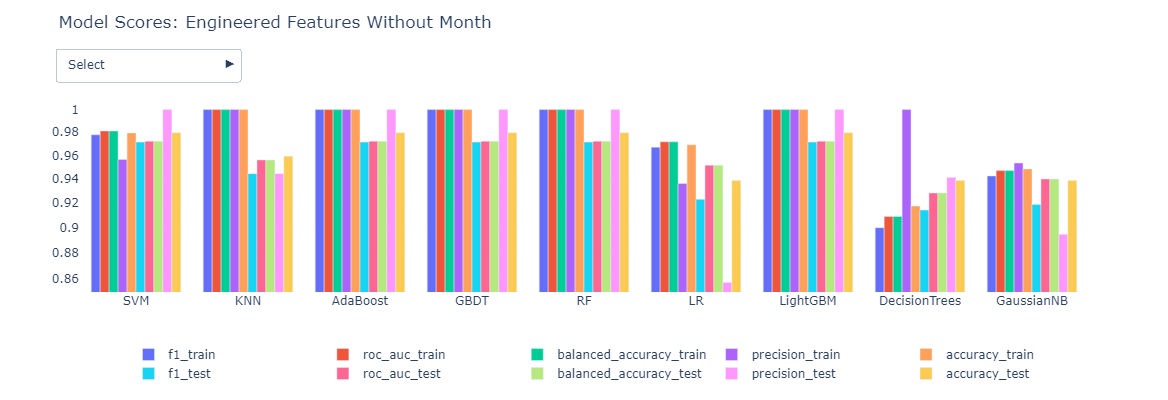

In [44]:
############################################################################################
df  = pd.read_csv('../Models/Classification_models/tuned_models_raw4_3_without_month//model_scores.csv')
#df = df.drop('Unnamed: 0', axis =1)
df = df.set_index('model')
df1 = df[['f1_train','roc_auc_train','balanced_accuracy_train','precision_train','accuracy_train']]
df2 = df[['f1_test','roc_auc_test','balanced_accuracy_test','precision_test','accuracy_test']]

#########################################################
import plotly.graph_objects as go


def multi_plot(df1,df2, title, addAll = True):
    
    fig = go.Figure()
    

    for column1 in df1.columns.to_list():
        f1= fig.add_trace(
            go.Bar(
                x = df1.index,
                y = df1[column1],
                name = column1,
            )
        )

    for column2 in df2.columns.to_list():
        fig.add_trace(
            go.Bar(
                x = df2.index,
                y = df2[column2],
                name = column2
            )
        )


    button_all = [dict(label = 'Train',
                      method = 'update',
                      args = [{'visible': df1.columns.isin(df1.columns),
                               'title': 'All',
                               'showlegend':True}]),
                  dict(label = 'Select',
                      method = 'update',
                      args = [{'visible': df2.columns.isin(df2.columns),
                               'title': 'All',
                               'showlegend':True}]),
                  
                  ]
                 
                

    def create_layout_button(column1):
        return dict(label = column1,
                    method = 'update',
                    args = [{'visible': df1.columns.isin([column1]),
                             'title': column1,
                             'showlegend': True}])
    
    def create_layout_button2(column2):
        return dict(label = column2,
                    method = 'update',
                    args = [{'visible': df2.columns.isin([column2]),
                             'title': column2,
                             'showlegend': True}]
                   )
    # Update remaining layout properties

    fig.update_layout(
        updatemenus=[
          
            
            go.layout.Updatemenu(
            active = 0,
            visible=True,
            buttons = ([button_all[1]] * addAll) + list(df2.columns.map(lambda column: create_layout_button2(column))),
               
            direction="right",
            pad={"r": 5, "t": 5,"l":5},
            showactive=True,
            x=-0.03,
            xanchor="left",
            y=1.1,
            yanchor="bottom"),
            
            
            
        ],
         yaxis_type="log"       
    )
    # Update remaining layout properties
    fig.update_layout(
        title_text=title,
        title_y=0.96,
        
        height=400,
        #width = 1000,
        showlegend=True,
        legend=dict(yanchor="bottom",
                                  y=-0.5,
                                  xanchor="center",
                                  x=0.5,
                                  orientation='h'),
        paper_bgcolor = "rgba(0,0,0,0)",
        plot_bgcolor = "rgba(0,0,0,0)",
        margin_autoexpand=True,
        autosize=True,
        
    )
    
    fig.show(scale=200, config= dict(displayModeBar = False))
       
    ############################################################
    
    # Writing and exporting interactive figure as html file 
    
    f1.write_html('../Models/Classification_models/tuned_models_raw4_3_without_month/Model_Scores.html',config= dict(displayModeBar = False))
        
########################################################################################

multi_plot(df1,df2, title="Model Scores: Engineered Features Without Month")  

#https://towardsdatascience.com/how-to-create-an-interactive-dropdown-in-jupyter-322277f58a68

# Feature Importance

In [ ]:
model = {"AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"RF":RF_model}
model.keys()

In [43]:
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.express as px
import plotly.io as pio
import pandas as pd



model = {"AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"RF":RF_model}
# Define the number of rows and columns for the subplot grid
num_rows = 1
num_cols = 3

# Create a subplot grid with the specified number of rows and columns
fig = sp.make_subplots(rows=num_rows, cols=num_cols,subplot_titles=list(model.keys()))

# Loop through each column in the dataframe and add a box plot to the subplot grid
for idx, col_name in enumerate(model):
    row_num = (idx // num_cols) + 1
    col_num = (idx % num_cols) + 1
    
    ###### Feature Imortance Dataframe ###############
    feature_importance = model.get(col_name).best_estimator_.feature_importances_

    feature_importance_df = pd.DataFrame({'feature': X_train.columns,
                                      'importance': feature_importance
                                     }).sort_values('importance', ascending=False)
    
    ############ Plotting Feature Importance ################
    
    fig.add_trace(px.bar(data_frame= feature_importance_df,x='feature',y='importance').data[0], row=row_num, col=col_num,)
    
    #########################################################
    
    # Set the title of the subplot grid
    fig.update_layout(height=500,width=1100, title='Feature Importance: Engineerd Features Without Month',
                      paper_bgcolor = "rgba(0,0,0,0)",
                      plot_bgcolor = "rgba(0,0,0,0)",                  
                     )
    fig.update_traces(marker_color='green')
# Show the plot
#fig.show()
###############################
fig.update_yaxes(showline=False,showgrid=False)
fig.update_xaxes(showline=False,showgrid=False)
##########################################
#pio.write_html(fig,file = '../Models/Classification_models/tuned_models_raw4_3_without_month/featureImportance.html',config= dict(displayModeBar = False))


# Validation Curve

In [ ]:
clfs = {
    'LogisticRegression': lr_model,
    'SVC': svm_model,
    'KNeighbors': knn_model,
    'RandomForest': RF_model,
    'AdaBoost': AdaBoost_model,
    
    'GradientBoostingTrees': GBDT_model
}

In [ ]:
param_grid = {
    
    'LogisticRegression':{                         
                          'max_iter':[100,1000,2000,3000],
                          'l1_ratio':[1,0.9,0.8,0.7,0.6,0.5,0.4,0.2,0],                          
                          'C': [10e-3,10e-2,10e-1,1.0,10,20,30],
                         },
    
    'SVC': {'C':[10e-2,10e-1,1.0,10,20,30,40,70],
           
           
           },
    
    'KNeighbors': {'n_neighbors':[3,5,9,11,13,15,19],  # n_neighbors should always be odd numbers
                     
                  },
    
    'RandomForest': {'n_estimators':[100,300,500],
                    
                    'max_depth':[2,4,5,6,7,8,10,15,20],
                    
                    },
    
    'AdaBoost': {'n_estimators': [50,70,90,100,110,140,170],
                'learning_rate': [10e-3,10e-2,10e-1,1.0]
                },
    
    'GradientBoostingTrees': {
                             'learning_rate': [10e-3,10e-2,10e-1,1.0],
                             'n_estimators': [100,200,400,600],
                             'max_depth': [2,3,4,5,6,7,8,9,11,15,20]
                             },
          
    }

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
fig.suptitle('Validation Curves for Different Classifiers:Engineered Features', fontsize=22, fontweight='bold', y=1.0)

axes = axes.flatten()
i = 0

for j, (clf_name, clf) in enumerate(clfs.items()):
    for k, (param_name,param_value) in enumerate(param_grid[clf_name].items()):
        ax = axes[i]
        i += 1
        
        train_scores, valid_scores = validation_curve(clf.best_estimator_,
                                                      X_train, y_train,
                                                      cv=3,
                                                      param_name=param_name,
                                                      param_range=param_value)
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        valid_mean = np.mean(valid_scores, axis=1)
        valid_std = np.std(valid_scores, axis=1)
        ax.set_title(f'{clf_name} - {param_name}')
        ax.set_xlabel(param_name)
        ax.set_ylabel('Score')
        ax.set_ylim(0.0, 1.1)
        ax.set_xscale('log') 
        lw = 2
        
        try:
            ax.semilogx(param_value, train_mean, label='Training score', color='darkorange', lw=lw)
        except:
            pass
        
        ax.fill_between(param_value, train_mean - train_std, train_mean + train_std, alpha=0.2, color='darkorange', lw=lw)
        
        try:
            ax.semilogx(param_value, valid_mean, label='Cross-validation score', color='navy', lw=lw)
        except:
            pass
        
        ax.fill_between(param_value, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='navy', lw=lw)
        ax.legend(loc='best')
        
plt.tight_layout()

#plt.show()

##########################################################

#fig.figure.savefig(f'../AutoViz_Plots/ValidationCurve/{name}_{key}.svg',transparent=True,dpi=300)

if not os.path.exists(f'../Results/Results_Classification/ValidationCurve_raw4_3'):
    os.makedirs(f'../Results/Results_Classification/ValidationCurve_raw4_3')
plt.savefig(f'../Results/Results_Classification/ValidationCurve_raw4_3/ValidationCurve_raw4_3.svg',format='svg',dpi=600)
#####################################################

plt.show()

# Learning Curve

In a classification problem, the learning curve shows the performance of a model on the training set and the validation set over increasing numbers of training samples. It shows how the performance of the model changes as the training set size increases. The performance metric used for classification learning curves is usually accuracy or F1 score.

In a regression problem, the learning curve shows the performance of a model on the training set and the validation set over increasing numbers of training samples. It shows how the performance of the model changes as the training set size increases. The performance metric used for regression learning curves is usually mean squared error (MSE) or R-squared.

In [ ]:
############## LEARNING CURVE #####################


#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.model_selection import learning_curve


############################################

#################################################
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.suptitle('Learning Curves For Classifiers: Engineered Features Without Month', fontsize=24, fontweight='bold', y=1.0)
axes = axes.flatten()
i = 0
###################################################


#for name, clf in {'SVM':svm_model, "AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"KNN":knn_model,"LogReg":lr_model,"RF":RF_model}.items():
model = {'SVM':svm_model, "AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"KNN":knn_model,"LogReg":lr_model,"RF":RF_model}


for name, clf in model.items():
    print("\nFor ",name)
    #parameters = param_grid[name]
    #gs = grid_search(clf,parameters)
    
    ax = axes[i]
    i +=1
   
    # split dataset into training and test data
    train_sizes, train_scores, test_scores = learning_curve(clf.best_estimator_, X_train, y_train,
                                                            cv=3,
                                                            verbose=0,
                                                            random_state=100,
                                                            #scoring=scoring,
                                                            train_sizes=np.linspace(0.1, 1.0, 4),)
    
    # calculate mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # plot learning curve
    #plt.figure()
    ax.set_title(f'Learning Curve: {name}')
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Score')
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    ax.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    ax.legend(loc='best')

plt.tight_layout()    
    
if not os.path.exists('../Results/Results_Classification/LearningCurve_raw4_3_without_month'):
    os.makedirs('../Results/Results_Classification/LearningCurve_raw4_3_without_month')
plt.savefig(f'../Results/Results_Classification/LearningCurve_raw4_3_without_month/LearningCurve_raw4_3_without_month.svg',format='svg',dpi=500)
    
plt.show()

    
    



# Complexity Aanalysis

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.model_selection import learning_curve


############################################

#################################################
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(10, 15))
fig.suptitle(' Scalability & Performance: Engineered Features Without Month', fontsize=24, fontweight='bold', y=1.0)
axes = axes.flatten()
i = 0
###################################################


#for name, clf in {'SVM':svm_model, "AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"KNN":knn_model,"LogReg":lr_model,"RF":RF_model}.items():
model = {'SVM':svm_model, "AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"KNN":knn_model,"LogReg":lr_model,"RF":RF_model}


for name, clf in model.items():
    print("\nFor ",name)
    
    ax = axes[i]
    ax2 = axes[i+1]
    ax3 = axes[i+2]
    i +=3
   
    # split dataset into training and test data
    train_sizes, train_scores, test_scores, fit_time, score_time = learning_curve(clf.best_estimator_, X_train, y_train,
                                                            cv=3,
                                                            verbose=0,
                                                            random_state=100,
                                                            #scoring=scoring,
                                                            train_sizes=np.linspace(0.1, 1.0, 4),
                                                           return_times=True)
    
    # calculate mean and standard deviation of training and test scores
    fit_time_mean = np.mean(fit_time, axis=1)
    fit_time_std = np.std(fit_time, axis=1)
    
    score_time_mean = np.mean(score_time, axis=1)
    score_time_std = np.std(score_time, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    

    # plot learning curve
    #plt.figure()
    ax.set_title(f'Scalability For: {name}')
    ax2.set_title(f'Scalability For: {name}')
    ax3.set_title(f'Performance of: {name}')
    
    ax.set_xlabel('Training examples')
    ax2.set_xlabel('Training examples')
    ax3.set_xlabel('Fit Time')
    
    ax.set_ylabel('Fit Time')
    ax2.set_ylabel('Score Time')
    ax3.set_ylabel('Test Score')
    
    ax.grid()
    ax2.grid()
    ax3.grid()
    
    ax.fill_between(train_sizes, fit_time_mean - fit_time_std, fit_time_mean + fit_time_std, alpha=0.1, color='r')
    ax2.fill_between(train_sizes, score_time_mean - score_time_std, score_time_mean + score_time_std, alpha=0.1, color='g')
    ax3.fill_between(fit_time_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='b')
    
    ax.plot(train_sizes, fit_time_mean, 'o-', color='r', label='Fit Time')
    ax2.plot(train_sizes, score_time_mean, 'o-', color='g', label='Score Time')
    ax3.plot(fit_time_mean, test_scores_mean, 'o-', color='b', label='Fit Time vs score')
    
    #ax.legend(loc='best')
    #ax2.legend(loc='best')

plt.tight_layout()    
    
if not os.path.exists('../Results/Results_Classification/ScalabilityPerformance_raw4_3_without_month'):
    os.makedirs('../Results/Results_Classification/ScalabilityPerformance_raw4_3_without_month')
plt.savefig(f'../Results/Results_Classification/ScalabilityPerformance_raw4_3_without_month/ScalabilityPerformance_raw4_3_without_month.svg',format='svg',dpi=600)
    
plt.show()

    
    



# ROC UC Curve

In [ ]:
#from sklearn.metrics import RocCurveDisplay

In [ ]:
#################################################
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8),sharex=True, sharey=True, squeeze=True)
fig.suptitle('ROC Curve: Engineered Features', fontsize=22, fontweight='bold', y=1)
axes = axes.flatten()
i = 0
###################################################


#for name, clf in {'SVM':svm_model, "AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"KNN":knn_model,"LogReg":lr_model,"RF":RF_model}.items():
model = {'SVM':svm_model, "AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"KNN":knn_model,"LogReg":lr_model,"RF":RF_model}


for name, clf in model.items():
    #print("\nFor ",name)
    
    ax = axes[i]
    
    roc_display = RocCurveDisplay.from_estimator(clf.best_estimator_,X=X_test, y= y_test, ax=ax,alpha=1,color='b')
    ax.set_title(name)
    ax.legend(loc='best')
    ax.grid(color='k',alpha=0.1)
    
    i +=1
plt.tight_layout()    

#################################
if not os.path.exists('../Results/Results_Classification/ROC_Curve_raw4_3'):
    os.makedirs('../Results/Results_Classification/ROC_Curve_raw4_3')
plt.savefig(f'../Results/Results_Classification/ROC_Curve_raw4_3/ROC_Curve_raww4_3.svg',format='svg',dpi=600)


# Confusion Metrix

In [ ]:
#from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#################################################
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), squeeze=True)
fig.suptitle('Confusion Metrix: Engineered Features', fontsize=22, fontweight='bold', y=1)
axes = axes.flatten()
i = 0
###################################################


#for name, clf in {'SVM':svm_model, "AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"KNN":knn_model,"LogReg":lr_model,"RF":RF_model}.items():
model = {'SVM':svm_model, "AdaBoost":AdaBoost_model, "GBDT":GBDT_model,"KNN":knn_model,"LogReg":lr_model,"RF":RF_model}


for name, clf in model.items():
    #print("\nFor ",name)
    
    ax = axes[i]
    
    confusionMetrix = ConfusionMatrixDisplay.from_estimator(clf.best_estimator_, X=X_test, y= y_test, ax=ax, colorbar=False)
    ax.set_title(name)
    
    i +=1

plt.tight_layout()    

#################################
if not os.path.exists('../Results/Results_Classification/ConfusionMetrix_raw4_3'):
    os.makedirs('../Results/Results_Classification/ConfusionMetrix_raw4_3')
plt.savefig(f'../Results/Results_Classification/ConfusionMetrix_raw4_3/ConfusionMetrix_raw4_3.svg',format='svg',dpi=600)
########
plt.show()

# VotingClassifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

#rf_model = RandomForestClassifier()
#lgbm_model = LGBMClassifier()

# Train the models on some training data

trained_models = [('rf', RF_model.best_estimator_), ('lgbm', lgbm_model.best_estimator_),
                  ('adaBoost', AdaBoost_model.best_estimator_),('GBDT',GBDT_model.best_estimator_)]

voting_clf = VotingClassifier(estimators=trained_models, voting='soft')

# Now you can use the voting classifier to make predictions directly using predict()


In [22]:
voting_clf_fitted = voting_clf.fit(X_train,y_train)


In [27]:
voting_clf_fitted.feature_names_in_

array(['month_07', 'month_08', 'month_09', 'Temperature', 'RH', 'Rain',
       'DC', 'FWI', 'FWI/FFMC', '(DMC/FWI)/ISI', 'FWI/BUI'], dtype=object)

In [24]:
voting_clf_fitted.predict(X_test)
roc_auc_score(y_test,voting_clf_fitted.predict(X_test))

0.9722222222222222

In [26]:
filename = 'VotingClassifier_raw4_3' + '_model.pkl'
filepath = os.path.join('../Models/Classification_models/VotingClassifier_raw4_3', filename)
with open(filepath, 'wb') as file:
    pickle.dump(voting_clf_fitted, file)


# <center>Conclusions: Classifiaction Problem</center>

- FWI is calculated from FFMC, DMC, ISI, BUI and these features hss very strong correlation reaching to 9 or more so decided to go with following strategie:

    - Selected Temperature, Rain, RH, DC and FWI and month
    - I understand standardization and some transformation like log(x+1) transformation is need for FWI and DC
    - I trained the model with standardization & transfromation, with only standardization, without standardization or transformation
    - Original features can't be accomodated because of high correlaion. Since FWI is calculated from other features so including those features and excluding the FWI will only complicate the model and there will be no improvement in perfromance. I also perfromed feature engineering so that I can include other features.
    - The generated features include: FWI/FFMC,  (DMC/FWi)/ISI, FWI/BUI
    - I trained the model with these features following same strategie i.e with and without transformation and with standardization & no transformation.
    - The best perfroming models in terms of F1, roc_auc, precision, balanced accuracy etc are the  models with engineered features with standardization. However the second best model was with original features including DC adn FWI without standardization and transformation.